In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import pytorch_lightning
import pytorchvideo.data
import torch.utils.data
import pandas as pd

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    RandomRotation
)

import os 
import csv
import json
from typing import List

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from pytorchvideo.data.encoded_video import EncodedVideo
from torchvision.transforms._transforms_video import NormalizeVideo

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import Video

import pytorchvideo.models.resnet
import torch
import torch.nn as nn
import torch.nn.functional as F

In [46]:
def with_opencv(filename):
    import cv2
    video = cv2.VideoCapture(filename)

    duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return int(duration), int(frame_count)

In [71]:
num_frames = 40

video_transform = ApplyTransformToKey(
    key="video",
    transform=T.Compose(
        [
            UniformTemporalSubsample(num_frames), 
            T.Lambda(lambda x: x / 255.0),  
            ShortSideScale(size=256),
            RandomHorizontalFlip(p=0.5),
            NormalizeVideo(mean=[0.54753108, 0.50075604, 0.5237918], std=[0.25779962, 0.24744116, 0.24499615]),
            # RandomRotation(10)
        ]
    ),
)

transform = T.Compose(
        [
            UniformTemporalSubsample(num_frames), 
            T.Lambda(lambda x: x / 255.0),  
            ShortSideScale(size=256),
            RandomHorizontalFlip(p=0.5),
            NormalizeVideo(mean=[0.54753108, 0.50075604, 0.5237918], std=[0.25779962, 0.24744116, 0.24499615]),
            # RandomRotation(10)
        ]
    )

class OneVideoDataset(Dataset):
    def __init__(self, filename, target_filename, window=2, train=True):
        super(OneVideoDataset).__init__()
        self.video = EncodedVideo.from_path(filename)
        self.window = window
        self.len = int(self.video.duration) - self.window * 2
        
        inp = open(target_filename, "r")
        self.y = np.array(list(map(int, inp.readline().split()))).astype(np.float64)

    def __getitem__(self, index):
        index += self.window
        return video_transform(self.video.get_clip(index - self.window, index + self.window))['video'], self.y[index]
    
    def __len__(self):
        return self.len

# class OneVideoDataset(Dataset):
#     def __init__(self, filename, window=60, train=True):
#         super(OneVideoDataset).__init__()
#         cap = cv2.VideoCapture(filename)

#         dur, frame_count = with_opencv(filename)

#         frames = []

#         for _ in tqdm(range(frame_count)):
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
#             frames.append(frame_rgb)
        
#         self.window = window
#         self.df = np.array(frames)
#         self.df = self.df.transpose((3, 0, 1, 2))
#         self.df = torch.tensor(self.df)
#         # print(self.df.shape)
#         self.len = self.df.shape[1] - window;
#         self.y = np.zeros(self.len + self.window).astype(int)

#     def __getitem__(self, index):
#         index += self.window
#         return transform(self.df[:, index - self.window : index + self.window]), self.y[index]
    
#     def __len__(self):
#         return self.len

In [72]:
from collections import defaultdict

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    loss_1 = []
    # for X, target in tqdm(loader, position=1, desc="batch", colour='red', ncols=80):
    for X, target in loader:
        X = X.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        pred = nn.Sigmoid()(model(X)[:, 0]).to(torch.float64)
        loss = criterion(pred, target)
        
        if ((target == 1.).sum() > 0):
            loss_1.append(pred[target == 1.].mean().item())
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    if len(loss_1) == 0:
        loss_1 = [-1.]
    
    return model, optimizer, np.mean(losses_tr), np.mean(loss_1)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    loss_1 = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        # for X, target in tqdm(loader, position=1, desc="batch", colour='red', ncols=80):
        for X, target in loader:
            X = X.to(device)
            target = target.to(device)

            pred = nn.Sigmoid()(model(X)[:, 0]).to(torch.float64)
            loss = criterion(pred, target)
            
            if ((target == 1.).sum() > 0):
                loss_1.append(pred[target == 1.].mean().item())

            losses_val.append(loss.item())
            
            # if metric_names is not None:
            #     if 'accuracy' in metric_names:
            #         preds = torch.argsort(pred, dim=-1, descending=True)
            #         for k in metric_names["accuracy"]["top"]:
            #             metrics[f'accuracy ~ top#{k}'].append(
            #                 np.mean([target[i] in preds[i, :k] for i in range(target.shape[0])])
            #             )
        # if metric_names is not None:
        #     for name in metrics:
        #         metrics[name] = np.mean(metrics[name])
    
    if len(loss_1) == 0:
        loss_1 = [-1.]
        
    return np.mean(losses_val), metrics if metric_names else None, np.mean(loss_1)

In [73]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_dir,
    train_files,
    val_dir,
    val_files,
    target_dir,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    batch_size=5,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):
    # Выбираем куда будем сохранять модель
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed = True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
        
    # Инициализируем переменные
    losses = {'train': [], 'val': []}
    losses1 = {'train': [], 'val': []}
    lrs = []
    count_1 = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()

    # Цикл обучения
    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        
        loss_tr = 0
        loss_tr_1 = []
        for file_n in tqdm(range(len(train_files)), position=0, desc="file train", colour='green', ncols=80):
            file = train_files[file_n]
            data = OneVideoDataset(
                os.path.join(train_dir, file),
                os.path.join(target_dir, file + ".txt")
            )
            dataloader = DataLoader(data,
                        batch_size,
                        shuffle=True)

            model, optimizer, loss, loss_1 = train(model, optimizer, dataloader, criterion)
            
            loss_tr += loss / len(train_files)
            
            if loss_1 != -1. :
                    loss_tr_1.append(loss_1)
        losses['train'].append(loss_tr)
        losses1['train'].append(np.mean(loss_tr_1))
        
        lrs.append(get_lr(optimizer))
        
        
        loss_val = 0
        loss_val_1 = []
            # Каждые val_every эпох проводим валидацию
        if not (epoch % val_every):
            for file_n in tqdm(range(len(val_files)), position=0, desc="file val", colour='green', ncols=80):
                file = val_files[file_n]
                data = OneVideoDataset(
                    os.path.join(val_dir, file),
                    os.path.join(target_dir, file + ".txt")
                )
                dataloader = DataLoader(data,
                            batch_size,
                            shuffle=True)
                
                loss, metrics_, loss_1 = val(model, dataloader, criterion, metric_names=metric_names)
                loss_val += loss / len(val_files)
                if loss_1 != -1. :
                    loss_val_1.append(loss_1)
                
            losses['val'].append(loss_val)
            losses1['val'].append(np.mean(loss_val_1))

            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)

            # Сохраняем лучшую по валидации модель
            if loss_val < best_val_loss:
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        # 'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name + '.pt'),
                )
                best_val_loss = loss_val

                # # Шаг шедулера
                # if scheduler:
                #     try:
                #         scheduler.step()
                #     except:
                #         scheduler.step(loss)

        # Каждые draw_every эпох рисуем графики
        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot_id", 1), metric_meta]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(isinstance(el[1], int) for el in plot_ids_)
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                assert all(el[1] >= 1 for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append((el[0], el[2]))
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(30, 10))
            fig.suptitle(f'#{epoch}/{epochs} ~ {timedelta(seconds=time.monotonic() - start_time)}')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('loss_1')
            plt.plot(losses1['val'], 'g.-', label='val')
            plt.plot(losses1['train'], 'g.-', label='train')
            plt.yscale("log")
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys_meta in plot_ids.items():
                    aggregated_meta = {}
                    plt.subplot(1, ww + ww_metrics, ww + plot_id)
                    if len(keys_meta) > 1:
                        plt.title(f'additional metrics #{plot_id}')
                    elif len(keys_meta) == 1:
                        plt.title(keys_meta[0][0])
                    for key_meta in keys_meta:
                        key, meta = key_meta
                        for meta_key in ["yscale"]:
                            if meta_key in meta:
                                assert meta_key not in aggregated_meta, f"Bad meta data '{meta_key}' doubled inside one plot_id ({plot_id})"
                                aggregated_meta[meta_key] = meta[meta_key]
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                    plt.yscale(aggregated_meta.get("yscale", "linear"))
                    plt.legend()
                    plt.grid()
            plt.show()
        
        # early_stopping - останавливаем обучение, если LR упал ниже min_lr
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


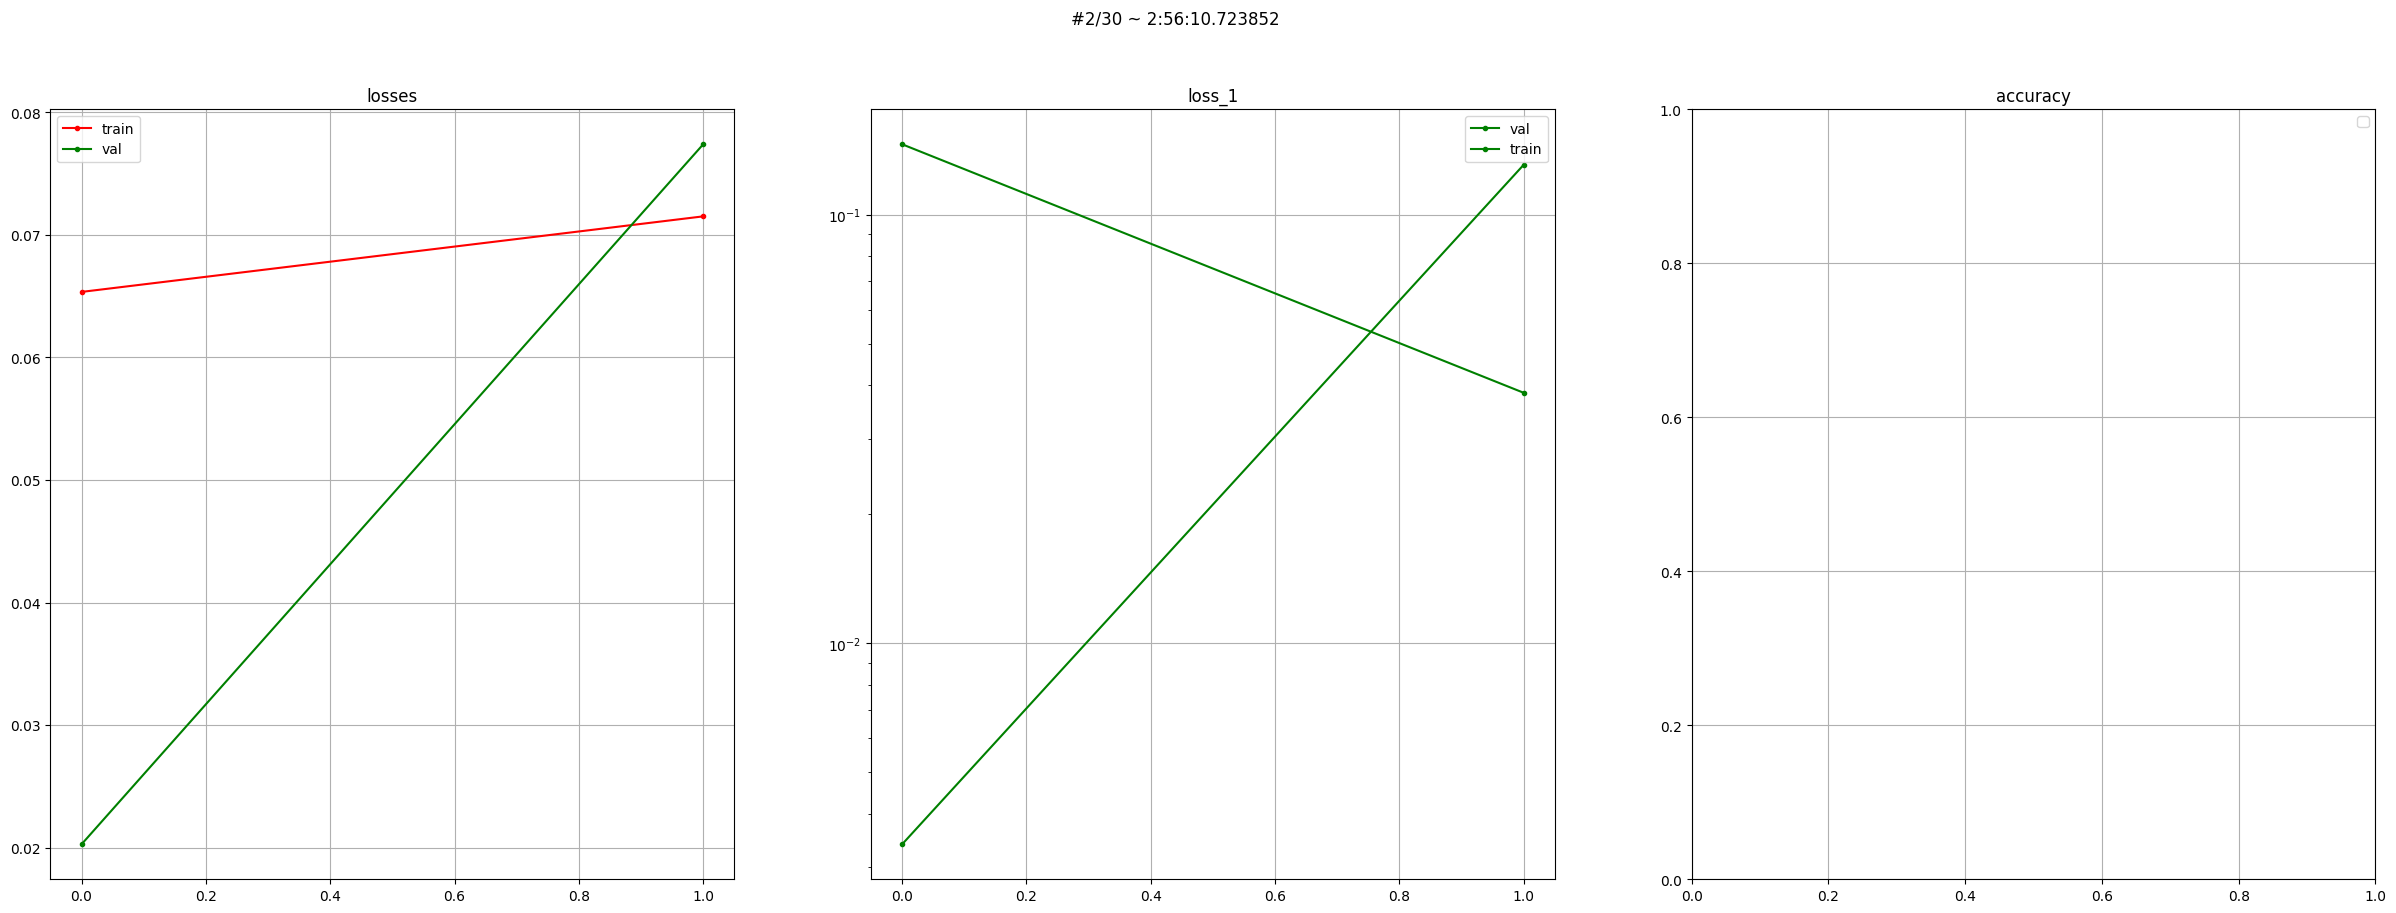

#3/30:


file train:  73%|██████████████████████▋        | 22/30 [07:35<02:45, 20.72s/it]


KeyboardInterrupt: 

In [77]:
%%time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = pytorchvideo.models.resnet.create_resnet(
            input_channel=3, # RGB input from Kinetics
            model_depth=50, # For the tutorial let's just use a 50 layer network
            model_num_class=1,
            norm=nn.BatchNorm3d,
            activation=nn.ReLU,
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

train_dir = 'data/train'
val_dir = 'data/val'
target_dir = 'data/target'

train_files = os.listdir(train_dir)[1:]
val_files = os.listdir(val_dir)[:-1]

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_dir = train_dir,
    train_files = train_files,
    val_dir = val_dir,
    val_files = val_files,
    target_dir = target_dir,
    criterion = criterion,
    scheduler = None,
    epochs = 30,
    min_lr = 1e-7,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    batch_size = 2,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "default",
)